# HW3

## Install and Set up the needed items

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
import pyspark
from pyspark import SparkContext, SparkConf
import re
import csv
import pandas as pd
import numpy as np

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 198 kB 59.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=fe4b049938141e9643739c8126f11f748ba3d569cd3c93c226b090c5a44cf5dc
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda

In [2]:
from google.colab import files
uploaded = files.upload()
uploaded = files.upload()

Saving centroid.txt to centroid.txt


Saving data.txt to data.txt


In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

##Read in the data

In [4]:
centroid = sc.textFile("centroid.txt") 
data = sc.textFile("data.txt")

In [5]:
# Split up the lines into floats
data = data.map(lambda line: [float(x) for x in line.split('\t')])
centroid = centroid.map(lambda line: [float(x) for x in line.split('\t')]).collect()

##Define the methods that we need

In [6]:

def euclidean(troid, line):
  sum = 0
  for i in range(20):
    sum += (line[i] - troid[i])**2
  sum = sum**0.5
  return sum

def minimum(line):
  """
  Find the closest centroid for the data point to be attached to
  """
  min_distance = float("inf")
  group = -1
  for x in range(len(centroid)):
    troid = centroid[x]
    distance = euclidean(troid, line) 
    if distance < min_distance:
      group = x
      min_distance = distance
  return (line, group)

def update_centroid(clusters):
  total_cost = 0
  for x in range(len(centroid)):
    tracker = 0
    total = [0 * x for x in range(20)]
    point = clusters.pop()
    #This while loop continues until we run out items in the clusters
    while point[1] == x:
      tracker += 1
      clust = point[0]
      sum = 0
      # Get the cost for this point to the centroid
      for i in range(20):
        total[i] += clust[i]
        sum += (clust[i] - centroid[x][i])**2
      total_cost += sum
      if len(clusters) == 0:
        break
      point = clusters.pop()
    # update the centroid to the new center for all it's points
    if tracker > 0:
      for i in range(20):
        total[i] = total[i] / tracker
      centroid[x] = total
  return total_cost

## Code to calculate new clusters for 20 rounds

In [7]:
total_cost = []
for _ in range(20):
  clusters = data.map(lambda line: minimum(line)).sortBy(lambda line: line[1], ascending=False).collect()
  cost = update_centroid(clusters)
  total_cost.append(cost)
  print(cost)

7788.285400000019
6761.511751636506
6492.488830273896
6318.487895990459
6204.631748447652
6117.324129572512
6027.476279406418
5984.037060959038
5964.33299125439
5953.085106048047
5949.7344418151415
5946.823951041479
5943.21584644777
5930.323322479352
5913.47273702306
5888.0842936627005
5886.46518098607
5886.351143635199
5886.351143635199
5886.351143635199


##Plot the costs for each round

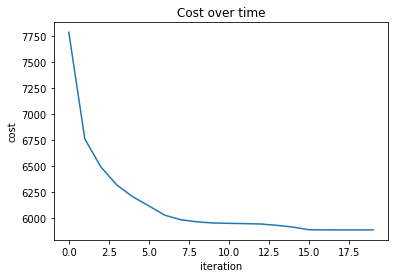

In [8]:
import matplotlib.pyplot as plt

plt.plot(total_cost)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost over time")
plt.show()